In [1]:
############    Loading Python Packages
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
sb.set_context(
    "talk",
    font_scale=1,
    rc={
        "lines.linewidth": 2.5,
        "text.usetex": True,
        "font.family": 'serif',
        "font.serif": 'Palatino',
        "font.size": 16
    })
from matplotlib import rc
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
# ## for Palatino and other serif fonts use:
# rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})

font = {'family': 'serif', 'serif': 'Palatino', 'weight': 'bold', 'size': 16}
rc('font', **font)
rc('text', usetex=True)

Let's import the data to a pandas dataframe so that we can manipulate the data easily. There were three power settings:
-20db, -15db and -12db and three frequency settings denoted by the time interval between the packets: 0.1s, 0.5s, and 1s

In [7]:
power = ['-20db', '-15db', '-12db']
time = ['0.1', '0.5', '1']
df = pd.DataFrame({
    'Distance': [],
    'Packets Sent': [],
    'Packets Received': [],
    'Power': [],
    'Relative Power': [],
    'Frequency': []
})

for p in power:
    for t in time:
        #filename = p + t + "secProb.txt"  # identify the filename
        filename = "noStack" + p + t + "secProb.txt"
        df_temp = pd.read_table(filename, delimiter=" ")
        df_temp.columns = ['Distance', 'Packets Sent', 'Packets Received']
        df_temp['Power'] = p
        df_temp['Relative Power'] = np.power(
            10, 
            (float(str(p).strip('db')) - float(str(power[2]).strip('db')))/10.0 # reference is -12db
        )
        df_temp['Frequency'] = 1. / np.float(t)
        if df.empty:  # for the first set of data, copy else append
            df = df_temp.copy()
        df = df.append(df_temp, ignore_index=True)
df['Probability'] = df['Packets Received'] / df['Packets Sent']

The probabilistic model for receiving $x$ packets, when $N$ packets are transmitted, where the probability of receiving a single packet $p$ is defined as follows. Let us assume a linear dependence as established from the first analysis. However, let us suppose that the coefficients regress on power and on frequency; we can also assume an interaction effect. All the coefficients are assumed to be Normal (mean=0).

$$p = \exp(\theta)$$ 
where
$$ \theta = b_0 + b_1 F_0 + b_2 P_0 + b_3 d + b_4 d P_0 $$
$$b_i \sim \mathrm{N}(\mu, \sigma^2)$$

The probability of receiving $x$ packets when $N$ packets are transmitted is given by:

$$ x \sim \binom{N}{p}$$

In [8]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=0, sd=10)
    b2 = pm.Normal('b2', mu=0, sd=10)
    b3 = pm.Normal('b3', mu=0, sd=10)
    b4 = pm.Normal('b4', mu=0, sd=10)

    # define linear model 
    theta = (b0 + 
             b1 * df['Frequency'] + 
             b2 * df['Relative Power'] +
             b3 * df['Distance'] +
             b4 * df['Distance']* df['Relative Power']
            )
    
    ## Define Binomial likelihood
    x = pm.Binomial(
        'x',
        n=df['Packets Sent'].values,
        p=np.exp(theta),
        observed=df['Packets Received'].values)
    trace = pm.sample(20000)
    burned_trace = trace[500:]  # getting rid of the initial part of the MCMC 

/Users/subham/miniconda3/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 20000/20000 [02:02<00:00, 163.49it/s]


Plotting the posterior distributions of the five parameters   $b_0 , b_1, b_2, b_3, b_4$

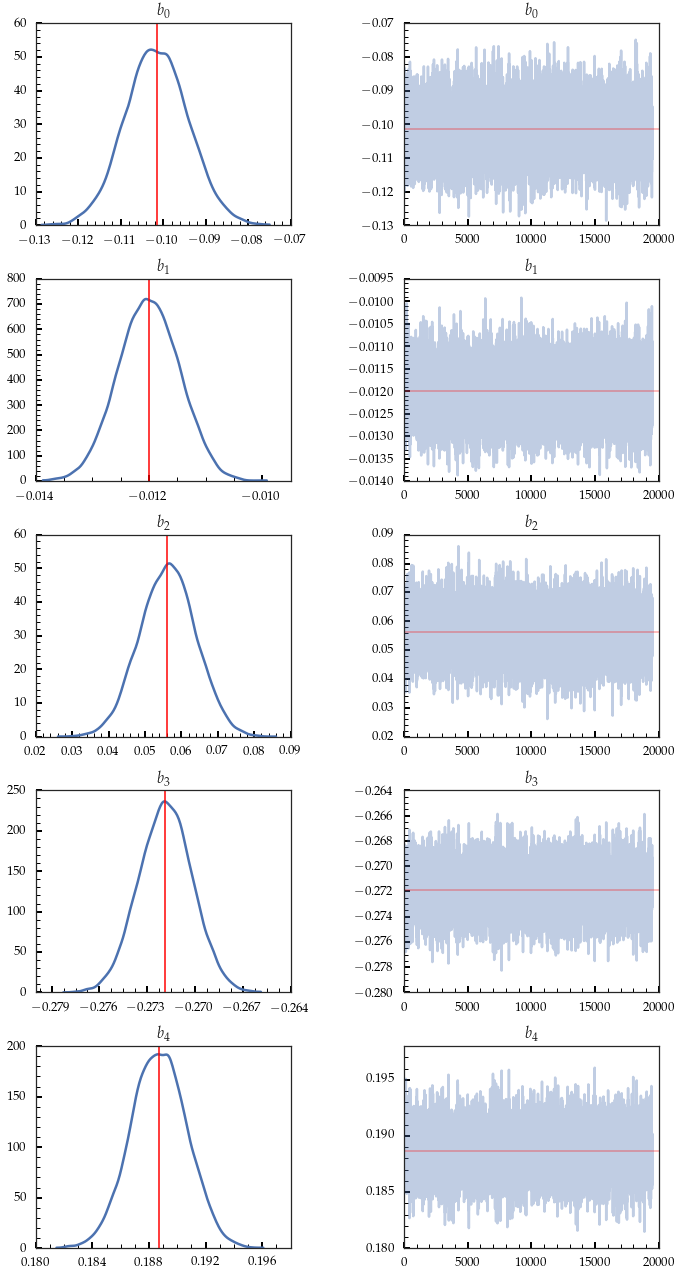

In [9]:
NRows = 5 # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.plt.subplots(NRows, NCols)  #### change on changing parameters
fig.set_size_inches(10, 18)

pm.plots.traceplot(
    trace=burned_trace,
    varnames=['b0', 'b1', 'b2', 'b3', 'b4'],
    lines={
        'b0': (burned_trace['b0']).mean(),
        'b1': (burned_trace['b1']).mean(),
        'b2': (burned_trace['b2']).mean(),
        'b3': (burned_trace['b3']).mean(),
        'b4': (burned_trace['b4']).mean(),
    },
    ax=axs)
# Setting up the axis titles , labels, ticks etc
axs[0,0].set_title(r"$b_0$")
axs[0,1].set_title(r"$b_0$")
axs[1,0].set_title(r"$b_1$")
axs[1,1].set_title(r"$b_1$")
axs[2,0].set_title(r"$b_2$")
axs[2,1].set_title(r"$b_2$")
axs[3,0].set_title(r"$b_3$")
axs[3,1].set_title(r"$b_3$")
axs[4,0].set_title(r"$b_4$")
axs[4,1].set_title(r"$b_4$")
axs[1,0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3,0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4,0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()

Now, we take samples from each of the distrubution. We can use the mean of these samples as MLE of the parameters.

In [10]:
b0_samples = burned_trace["b0"][:, None]  # best to make them 1d
b1_samples = burned_trace["b1"][:, None]
b2_samples = burned_trace["b2"][:, None]
b3_samples = burned_trace["b3"][:, None]
b4_samples = burned_trace["b4"][:, None]

beta = [b0_samples, b1_samples, b2_samples, b3_samples, b4_samples]

#### Taking the range of distance covered in our data
d = np.linspace(df.min()['Distance'], df.max()['Distance'] + 1,
                100)[:, None]  #distance range

We are now defining a function that returns the fitted value for a particular combination of frequency, power and distance

In [11]:
def theta(beta, frequency, power, distance):
    t = (beta[0] + 
         beta[1] * frequency + 
         beta[2] * power + 
         beta[3] * distance +
         beta[4] * distance * power)
    return np.exp(t)

Now we plot the fitted curve against the actual raw data. 

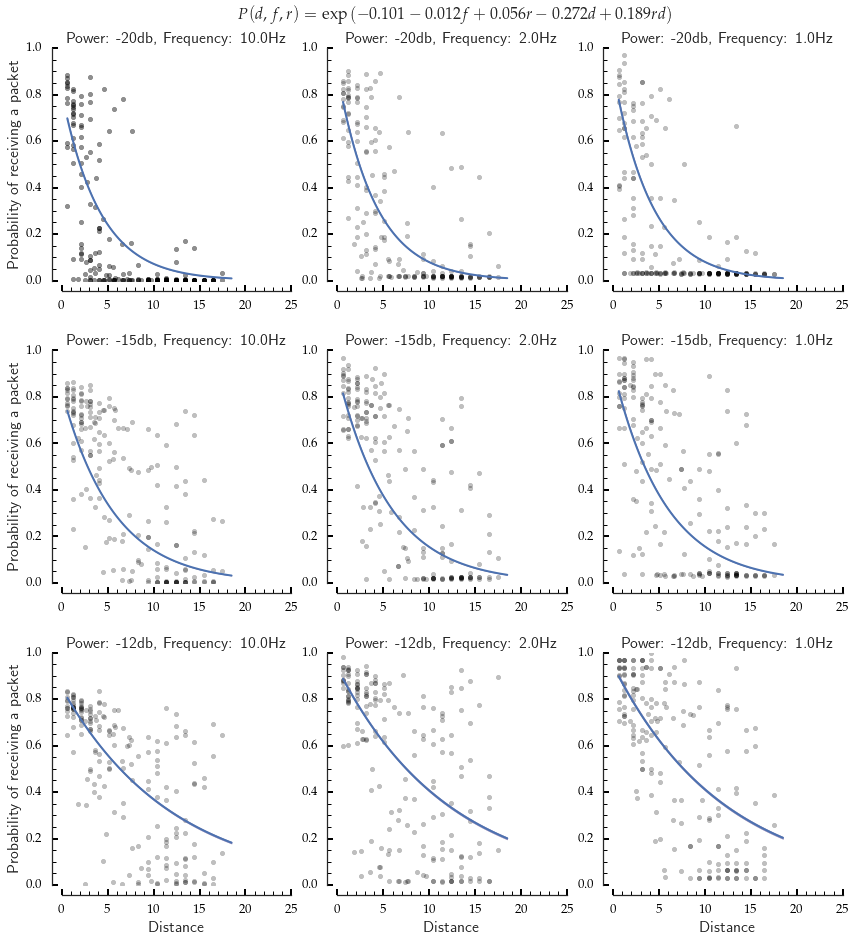

In [14]:
from scipy.stats.mstats import mquantiles

fig, axs = sb.plt.subplots(3, 3, sharey=True, sharex=True, figsize=(14, 15))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

#### Setting up the title which will give MLE of our model. 
s = "P(d,f,r) = \\exp \\left ({0:+.3f} {1:+.3f}f {2:+.3f}r {3:+.3f} d {4:+.3f}r d \\right )".format(
    beta[0].mean(), beta[1].mean(), beta[2].mean(), beta[3].mean(),
    beta[4].mean())

fig.text(0.3, 0.93, r"${0}$".format(s), va='center')

sb.set_style("white")

for t_index, t in enumerate(time):

    Frequency = 1. / np.float(t)  # fixing the frequency
    
    for p_index, p in enumerate(power):
        Power = p    # fixing the power
        RelativePower = np.power(
            10,
            (float(str(p).strip('db')) - float(str(power[2]).strip('db'))) /
            10.0  # reference is -12db
        )
        #### getting the raw data for a combination of power and frequency
        plot_data = df[(df.Power == Power) & (df.Frequency == Frequency)]
        Distance = plot_data['Distance']
        PktSent = plot_data['Packets Sent']
        PktRecvd = plot_data['Packets Received']
        #### getting the fitted value
        p_d = theta(
            beta=beta, frequency=Frequency, power=RelativePower, distance=d.T)
        mean_prob_d = p_d.mean(axis=0)
        #### plotting the fitted value
        axs[p_index,t_index].plot(d, mean_prob_d, linewidth=2)
        #### plotting the raw data
        axs[p_index,t_index].scatter(x=Distance,y=PktRecvd / PktSent,color='k',alpha=0.25)
        axs[p_index,t_index].set_title(r"Power: {0}, Frequency: {1}Hz".format(Power, Frequency),
                                       fontsize=16)

        qs = mquantiles(p_d, [0.025, 0.975], axis=0)
        axs[p_index,t_index].fill_between(d[:, 0], *qs, alpha=0.7, color="#7A68A6")
        axs[p_index,t_index].set_ylim(0, 1.0)
        axs[p_index,t_index].set_xlim(0, 25)
        axs[p_index,t_index].tick_params(direction='in', length=6, width=2, colors='k', which='major')
        axs[p_index,t_index].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
        axs[p_index,t_index].minorticks_on()  # need to set the minor ticks on explicity
        if t_index ==0:
            axs[p_index,t_index].set_ylabel("Probability of receiving a packet", fontsize=16)
        if p_index ==2:
            axs[p_index,t_index].set_xlabel("Distance", fontsize=16)

    sb.despine(offset=10, trim=False)

Now we plot the fitted curve for the various stack parameters i.e. noStack, oneStack, twoStacks. We plot only for packet interval of 0.1 seconds i.e 10Hz frequency.
Use the respective data files to train a model seperately for each of the cases.

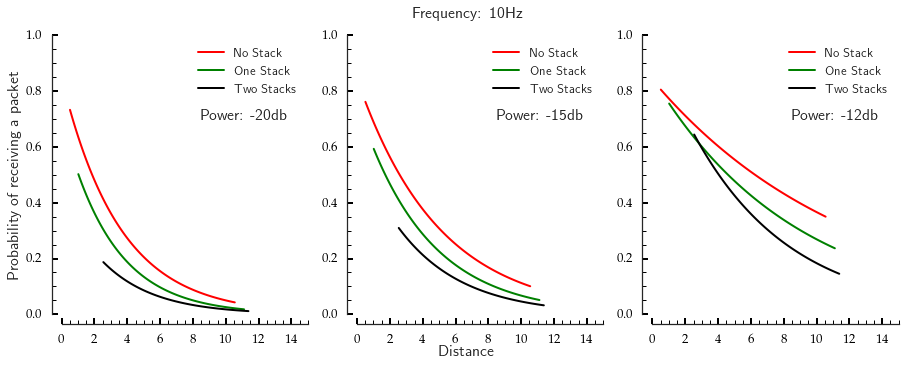

In [12]:
sb.set_style("white")
fig,axs = sb.plt.subplots(ncols=3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.text(0.5, 0.01, 'Distance', ha='center')

fig.text(0.45, 0.96, "Frequency: 10Hz", va='center')


Frequency = 1. / np.float(time[0])  # fixing the frequency


for p_index, p in enumerate(power):
    Power = p
    RelativePower = np.power(
            10,
            (float(str(p).strip('db')) - float(str(power[2]).strip('db'))) /
            10.0  # reference is -12db
    )
    #### getting the noStack case
    p_d = theta(
        beta=beta, frequency=Frequency, power=RelativePower, distance=d.T)
    mean_prob_d = p_d.mean(axis=0)
    #### getting the oneStack case
    p_d1 = theta(
        beta=beta1, frequency=Frequency, power=RelativePower, distance=d1.T)
    mean_prob_d1 = p_d1.mean(axis=0)
    #### getting the twoStacks case
    p_d2 = theta(
        beta=beta2, frequency=Frequency, power=RelativePower, distance=d2.T)
    mean_prob_d2 = p_d2.mean(axis=0)
    #### plotting the noStack, oneStack and twoStacks cases subsequently. 
    axs[p_index].plot(d, mean_prob_d, color='red', linewidth=2)
    axs[p_index].plot(d1, mean_prob_d1, color='green', linewidth=2)
    axs[p_index].plot(d2, mean_prob_d2, color='black', linewidth=2)

    s = "Power: {0}".format(Power)
    axs[p_index].annotate(s, xy=(8.5,0.7))
    axs[p_index].legend(["No Stack", "One Stack", "Two Stacks"])
    axs[p_index].set_ylim(0, 1.0)
    axs[p_index].set_xlim(0, 15)
    axs[p_index].tick_params(direction='in', length=6, width=2, colors='k', which='major')
    axs[p_index].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    axs[p_index].minorticks_on()  # need to set the minor ticks on explicity
    if p_index ==0:
        axs[p_index].set_ylabel("Probability of receiving a packet", fontsize=16)
    sb.despine(offset=10, trim=False)